In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.metrics import mean_squared_error

from src.data_processing.pipelines.ClassifierPipe import ClassifierPipe


In [4]:
DATA_PATH = '/projects/p31961/gaby_data/aggregated_data/raw_data/datasets/raw_data_raw_data.parquet.gzip'

In [5]:
processor_pipe = (ClassifierPipe(DATA_PATH)
             .read_raw_data()
             .calculate_max_min_signal()
             .calculate_percent_avoid()
             .drop_columns(["event", "action", "trial", "trial_count", "num_avoids", "max_trial"])
             .split_data(test_size=0.2,
                test_dev_size=0.5, 
                split_group = "mouse_id", 
                stratify_group = "sex", 
                target='ratio_avoid',
                save_subject_ids=False)
                # path_to_save =os.path.dirname(raw_path)
            .transorm_data()
)


In [6]:
space = {
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1)

}
trials = Trials()

def obejective(params):
    max_depth = int(params['max_depth'])
    n_estimators = int(params['n_estimators'])
    learning_rate = float(params['learning_rate'])
    min_child_weight = int(params['min_child_weight'])
    
    xg_model = xgb.XGBRegressor(objective='reg:squarederror', 
                                n_estimators=n_estimators,
                                max_depth = max_depth,
                                learning_rate = learning_rate,
                                min_child_weight = min_child_weight, 
                                eval_metric=['rmse', 'mae'])
    model = xg_model.fit(processor_pipe.X_train, processor_pipe.y_train)
    # return model.score(processor_pipe.X_dev, processor_pipe.y_dev)
    return mean_squared_error(processor_pipe.y_dev, model.predict(processor_pipe.X_dev))

def run_experiment():
    best = fmin(obejective, space, algo=tpe.suggest, max_evals=10, trials=trials)
    return best

best = run_experiment()



100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.41trial/s, best loss: 0.1598045427443738]


In [17]:
arr = np.array([1,2,3])

best["max_depth"] = arr
best

{'learning_rate': 0.19889704360046595,
 'max_depth': array([1, 2, 3]),
 'min_child_weight': 5.0,
 'n_estimators': 500.0}

In [50]:

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', 
                            #  n_estimators = 100, 
                            #  max_depth =3,
                            #  learning_rate = .01,
                            # #  min_child_weight = 3,
                            #  eval_metric=['rmse', 'mae']
                            )
xgb_model.fit(processor_pipe.X_train, processor_pipe.y_train, eval_set = [(processor_pipe.X_dev, processor_pipe.y_dev)])

[0]	validation_0-rmse:0.16912


[1]	validation_0-rmse:0.24096
[2]	validation_0-rmse:0.29599
[3]	validation_0-rmse:0.33320
[4]	validation_0-rmse:0.35621
[5]	validation_0-rmse:0.37643
[6]	validation_0-rmse:0.38688
[7]	validation_0-rmse:0.39699
[8]	validation_0-rmse:0.40343
[9]	validation_0-rmse:0.40788
[10]	validation_0-rmse:0.41109
[11]	validation_0-rmse:0.41329
[12]	validation_0-rmse:0.41459
[13]	validation_0-rmse:0.41493
[14]	validation_0-rmse:0.41550
[15]	validation_0-rmse:0.41619
[16]	validation_0-rmse:0.41632
[17]	validation_0-rmse:0.41643
[18]	validation_0-rmse:0.41622
[19]	validation_0-rmse:0.41648
[20]	validation_0-rmse:0.41621
[21]	validation_0-rmse:0.41638
[22]	validation_0-rmse:0.41654
[23]	validation_0-rmse:0.41635
[24]	validation_0-rmse:0.41635
[25]	validation_0-rmse:0.41638
[26]	validation_0-rmse:0.41629
[27]	validation_0-rmse:0.41630
[28]	validation_0-rmse:0.41633
[29]	validation_0-rmse:0.41633
[30]	validation_0-rmse:0.41640
[31]	validation_0-rmse:0.41638
[32]	validation_0-rmse:0.41638
[33]	validation_0

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Axes: xlabel='day', ylabel='predicted_avoid_ratio'>

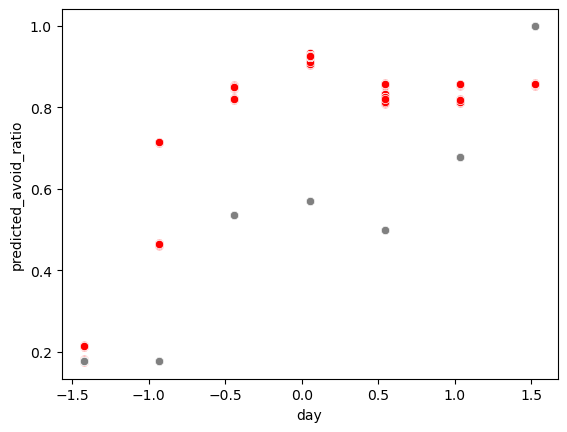

In [53]:
mse = mean_squared_error(processor_pipe.y_test, xgb_model.predict(processor_pipe.X_test))
num_cols = processor_pipe.processor.named_transformers_["num"].get_feature_names_out().tolist()
cat_cols = processor_pipe.processor.named_transformers_["cat"].get_feature_names_out().tolist()
cols = num_cols + cat_cols

testing_df = (pd.DataFrame(processor_pipe.X_test, columns=cols)
              .assign(predicted_avoid_ratio = xgb_model.predict(processor_pipe.X_test), 
                      true_avoid_ratio = processor_pipe.y_test)
                      )

sns.scatterplot(data=testing_df, x="day", y="predicted_avoid_ratio", color = 'red')
sns.scatterplot(data=testing_df, x="day", y="true_avoid_ratio", color = 'grey')

<Axes: >

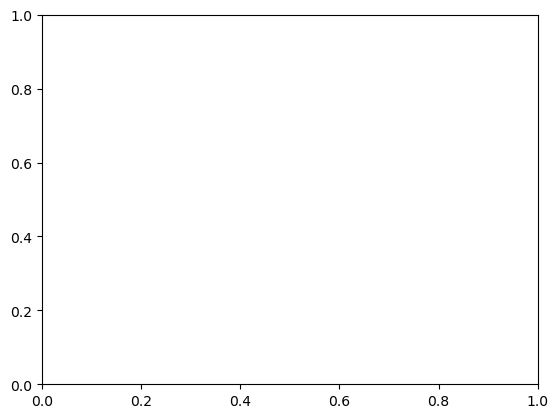

In [56]:
val_df = (pd.DataFrame(processor_pipe.X_dev, columns=cols)
              .assign(predicted_avoid_ratio = xgb_model.predict(processor_pipe.X_dev), 
                      true_avoid_ratio = processor_pipe.y_dev)
                      )
# sns.scatterplot(data=val_df, x="day", y="predicted_avoid_ratio", color = 'red')
sns.scatterplot(data=val_df, x="day", y="true_avoid_ratio", color = 'grey')

In [21]:
from sklearn.model_selection import GridSearchCV
search_space = {
    'max_depth': np.arange(3, 15,1),
    'n_estimators': np.arange(10, 1000, 100),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_child_weight': np.arange(1, 10, 1)

}

model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric=['rmse', 'mae'])
grid = GridSearchCV(model, search_space, cv=5)
grid.fit(processor_pipe.X_train, processor_pipe.y_train)

print(f"Best params: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

Best params: {'learning_rate': 0.2, 'max_depth': 11, 'min_child_weight': 1, 'n_estimators': 110}
Best score: 0.9999998238292485


In [7]:
model = xgb.XGBRegressor(objective='reg:squarederror', 
                          learning_rate=0.2, 
                          max_depth = 11, 
                          n_estimators = 110, 
                          min_child_weight = 1,
                          eval_metric=['rmse', 'mae'])
model.fit(processor_pipe.X_train, processor_pipe.y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['rmse', 'mae'],
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=11,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=110, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

In [8]:
pred = model.predict(processor_pipe.X_test)

0.03673547123511564


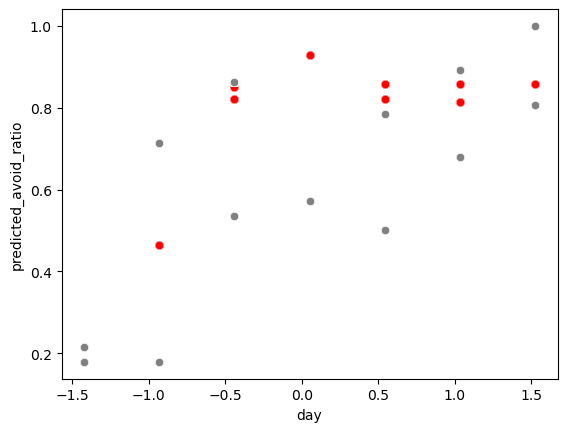

In [34]:
mse = mean_squared_error(processor_pipe.y_test, pred)
num_cols = processor_pipe.processor.named_transformers_["num"].get_feature_names_out().tolist()
cat_cols = processor_pipe.processor.named_transformers_["cat"].get_feature_names_out().tolist()
cols = num_cols + cat_cols

testing_df = (pd.DataFrame(processor_pipe.X_test, columns=cols)
              .assign(predicted_avoid_ratio = pred, 
                      true_avoid_ratio = processor_pipe.y_test.reset_index(drop=True))
                      )

sns.scatterplot(data=testing_df, x="day", y="predicted_avoid_ratio", color = 'red', alpha = 0.05)
sns.scatterplot(data=testing_df, x="day", y="true_avoid_ratio", color = 'grey')
print(mse)

<Axes: xlabel='day', ylabel='predicted_avoid_ratio'>

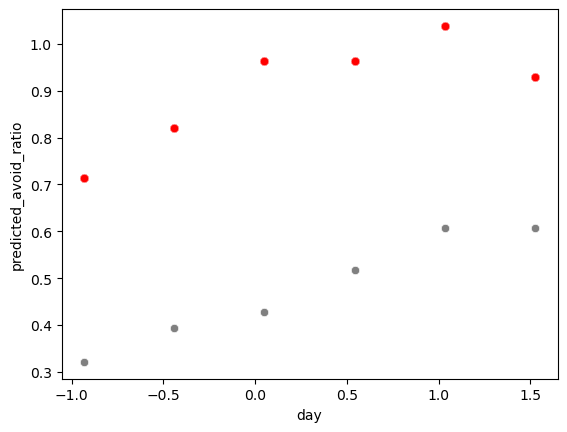

In [35]:
dev_pred = model.predict(processor_pipe.X_dev)
dev_mse = mean_squared_error(processor_pipe.y_dev, dev_pred)
dev_mse
dev_df = (pd.DataFrame(processor_pipe.X_dev, columns=cols)
          .assign(predicted_avoid_ratio = dev_pred,
                  true_avoid_ratio = processor_pipe.y_dev.reset_index(drop=True))
          )

sns.scatterplot(data=dev_df, x="day", y="predicted_avoid_ratio", color = 'red', alpha = 0.05)
sns.scatterplot(data=dev_df, x="day", y="true_avoid_ratio", color = 'grey')

<Axes: xlabel='day', ylabel='predicted_avoid_ratio'>

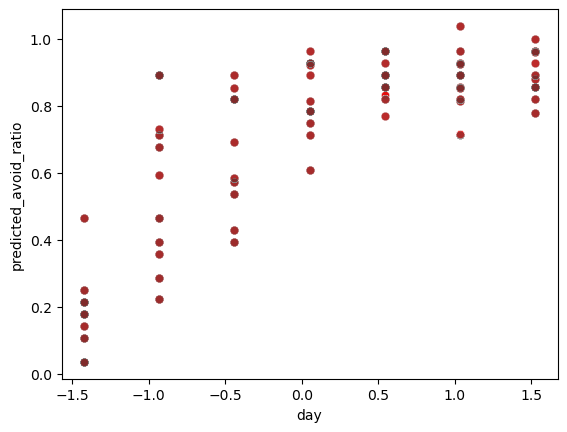

In [41]:
train_pred = model.predict(processor_pipe.X_train)
train_mse = mean_squared_error(processor_pipe.y_train, train_pred)
train_df = (pd.DataFrame(processor_pipe.X_train, columns=cols)
          .assign(predicted_avoid_ratio = train_pred,
                  true_avoid_ratio = processor_pipe.y_train.reset_index(drop=True))
          )

sns.scatterplot(data=train_df, x="day", y="predicted_avoid_ratio", color = 'red')
sns.scatterplot(data=train_df, x="day", y="true_avoid_ratio", color = 'grey', alpha=.01)